# Проверка работы нейросети для областей одинаковых товаров
рисование картинок   
вычисление symmetric_best_dice   

In [1]:
from ovotools.params import AttrDict
import sys
sys.path.append('../..')
import local_config
from os.path import join
model_name = 'NN_results/yolov3_points_fixbb_03cbf3'
model_fn = join(local_config.data_path, model_name)

params = AttrDict.load(model_fn + '.param.txt', verbose = True)
model_fn += '/models/04000.t7'
#params.data.net_hw = (416, 416) #(416, 416) #(512,768) ###### (1024,1536) #
params.data.batch_size = 4 #######
params.model_params.cfg = '../' + params.model_params.cfg
params

loaded from D:\Programming\Braille\Data\NN_results/yolov3_points_fixbb_03cbf3.param.txt


{
'model_name' : 'NN_results/yolov3_points_fixbb',
'data' : {
'get_points' : True,
'batch_size' : 4,
'mean' : (0.4138001444901419, 0.4156750182887099, 0.3766904444889663),
'std' : (0.2965651186330059, 0.2801510185680299, 0.2719146471588908),
'net_hw' : (256, 256), 
},
'model' : 'yolov3',
'model_params' : {
'cfg' : '../yolov3_points1.cfg', 
},
'optim' : 'torch.optim.Adam',
'optim_params' : {
'lr' : 0.001, 
}, 
}

In [2]:
import torch
import torch.nn as nn
from torchvision.transforms.functional import to_tensor

import matplotlib.pyplot as plt

from os import listdir

%matplotlib inline
import numpy as np
from PIL import Image
import PIL

import albumentations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
sys.path.append('..')
import DSBI_invest.data
import my_models

#sys.path.append(local_config.global_3rd_party + '/yolov3')
#import create_model_yolov3; create_model_yolov3 = reload(create_model_yolov3)

#import local_config; local_config = reload(local_config)

In [5]:
model, collate_fn, loss = my_models.create_model(params, '')
model.load_state_dict(torch.load(model_fn))
model.eval()
print("Model loaded")

Model loaded


# Отрисовка демо

In [6]:
def TensorToPilImage(tensor, params):
    vx_np = tensor.cpu().numpy().copy()
    vx_np *= np.asarray(params.data.std)[:, np.newaxis, np.newaxis]
    vx_np += np.asarray(params.data.mean)[:, np.newaxis, np.newaxis]
    vx_np = vx_np.transpose(1,2,0)*255
    return PIL.Image.fromarray(vx_np.astype(np.uint8))

In [7]:
train_loader, (val_loader1, val_loader2) = DSBI_invest.data.create_dataloaders(params, collate_fn = collate_fn)
val_loader1_it = iter(val_loader1)
data, target = next(val_loader1_it)

In [8]:
data[0].min(), data[0].max()

(tensor(-0.75076), tensor(1.97663))

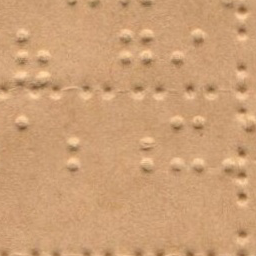

In [9]:
pil_img = TensorToPilImage(data[0], params)
pil_img

In [10]:
model.eval()
with torch.no_grad():
    inf_out, train_out = model(data.cuda())


In [14]:
loss_val = loss(train_out, target.to(device))
loss_val, loss.loss_dict

(tensor(4.91856, device='cuda:0'),
 defaultdict(float,
             {'total': 4.918558120727539,
              'xy': 0.5478307008743286,
              'wh': 1.9728294610977173,
              'conf': 2.397897958755493,
              'cls': 0.0}))

In [26]:
conf_thres = 0.1
nms_thres = 0.1
import utils.utils
inf_out[:,:,5] = 1
output = utils.utils.non_max_suppression(inf_out, conf_thres=conf_thres, nms_thres=nms_thres)
output

[None, None, None, None]

In [36]:
inf_out[0,4].min()

tensor(9.31963e-08, device='cuda:0')

/home/orwell/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


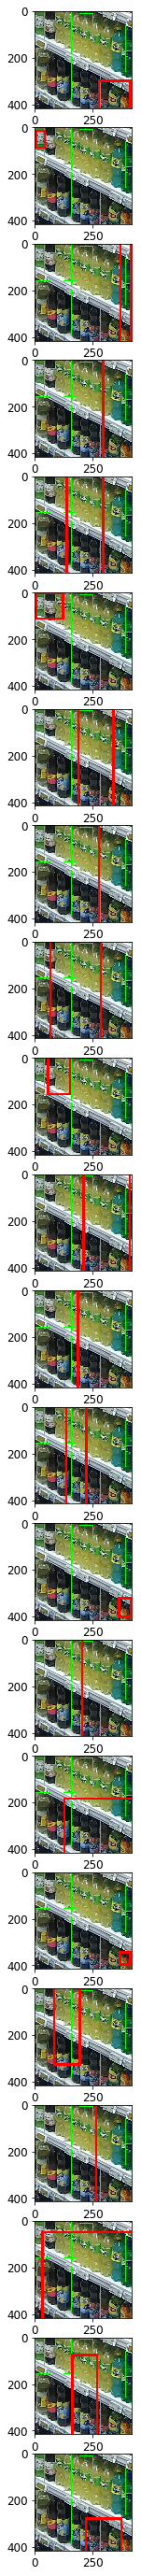

In [8]:
pil_img0 = pil_img
plt.figure(figsize=(20,50))

def draw_rectangle(draw, coordinates, color, width=1):
    w = coordinates[2] - coordinates[0]
    h = coordinates[3] - coordinates[1]
    width = min(width, int(w.item())//2, int(h.item())//2)
    for i in range(width):
        rect_start = (coordinates[0] - i, coordinates[1] - i)
        rect_end = (coordinates[2] + i, coordinates[3] + i)
        draw.rectangle((rect_start, rect_end), outline = color)

for bbi in range(output[0].shape[0]):
    bb = output[0][bbi]
    pil_img = pil_img0.copy()
    draw = PIL.ImageDraw.Draw(pil_img)
    draw_rectangle(draw, list(bb[:4]), color=(255,0,0), width=10)
    plt.subplot(output[0].shape[0], 1, bbi+1)
    plt.imshow(pil_img)



In [33]:
loss.get_dict()

defaultdict(float,
            {'total': 12.351089477539062,
             'xy': 1.4303500652313232,
             'wh': 1.222847819328308,
             'conf': 9.697891235351562,
             'cls': 0.0})

In [ ]:
from scipy import ndimage as ndi
numpy = np
y_np = p_numpy
#instances = dc.utils.postprocess(y_np, 40)
picture = numpy.argmax(y_np, 0)
#picture[0 == instances] = 0
'''
for obj in numpy.unique(instances)[1:]:
    innermask = numpy.zeros_like(instances)
    innermask[instances == obj] = 1
    distance = ndi.distance_transform_edt(innermask)
    #r, c = numpy.unravel_index(distance.argmax(), distance.shape)
'''
Image.fromarray(np.uint8(picture*50))


In [ ]:
import skimage
def postprocess(mapsx):
    object_index = 1
    argmaxes = numpy.argmax(mapsx, axis=0)
    output = numpy.zeros_like(mapsx[0, :, :])

    for i in range(1, mapsx.shape[0]):
        contours = skimage.measure.find_contours(argmaxes == i, 0.5)
        for c in contours:
            rr, cc = skimage.draw.polygon(c[:, 0], c[:, 1])
            output[rr, cc] = object_index
            object_index += 1
    return argmaxes


output = postprocess(p_numpy)
Image.fromarray(np.uint8(output*50))

In [ ]:
_ = dice_loss.inner_halo_to_individual(p[0])


In [ ]:
#print(best_dice(_,_[:22]))
i1=0
i2=300
#print(best_dice(_[i1:i2],_[i1:i2]))
print(dice_loss.best_dice(_[i1:i2],_[i1:i2]))
print(dice_loss.symmetric_best_dice(_[i1:i2],_[i1:i2]))

In [ ]:
data.LayeredTensorToPilImage(_)

# Тест FAR-FRR

In [ ]:
from imp import reload
#import deepcoloring as dc; dc = reload(dc)
import data; data = reload(data)
import inner_halo; inner_halo = reload(inner_halo)
import my_models; my_models = reload(my_models)
import dice_loss; dice_loss = reload(dice_loss)


import local_config; local_config = reload(local_config)

In [ ]:
mask_builder = inner_halo.build_inner_halo_mask(**params.inner_halo_params)

In [ ]:
_, test_loader = data.CreateAlbuLoadersV3(params, workers = 0, label_builder = mask_builder)

In [ ]:
import dice_loss; dice_loss = reload(dice_loss)

def flatten(x):
    return x.view(x.size(0), -1)

from tqdm import tqdm
net.eval()
net_par = net.cuda() #=torch.nn.DataParallel(net)
s = 0
d_types_num = 0
s_types_num = 0
fars = 0
frrs = 0
n = 0
min_gt = 1000000
for i, (x, gt) in enumerate(test_loader):
    x_t = x.to(device)
    ghost_mask = gt[0].to(device)
    class_halo_mask = gt[4].to(device)
    with torch.set_grad_enabled(False):
        pred = net_par(x_t)
        pred_class_halo = pred[1]
        n += x.shape[0]
        min_count=100
        s += dice_loss.inner_halo_symmetric_best_dice_batch(pred_class_halo, class_halo_mask.long(), mask=ghost_mask, min_count=min_count) * x.shape[0]
        
        fars_i, frrs_i, _ = dice_loss.inner_halo_hungry_x_y_fit(pred_class_halo, class_halo_mask.long(), mask=ghost_mask, min_count=min_count)        
        fars += sum(fars_i)
        frrs += sum(frrs_i)
        
        for b in range(x.shape[0]):
            inf = dice_loss.inner_halo_to_individual(pred_class_halo[b])[1:]
            inf_n = flatten(inf).sum(dim=1)
            types_inf = inf[inf_n>min_count].shape[0]
            gt = dice_loss.labels_to_individual(class_halo_mask[b])[1:]
            gt_n = flatten(gt).sum(dim=1)
            if min_gt > gt_n.min():
                min_gt = gt_n.min()
            types_gt = gt[gt_n > min_count].shape[0]
            #print(' gt ', types_gt, 'inf ', types_inf-types_gt)
            d_types_num += types_gt
            s_types_num += abs(types_inf-types_gt)
            gt_n = gt = inf_n = inf = None
            
        print(i,types_gt,types_inf,fars_i,frrs_i)
    x = gt = pred_class_halo = x_t = pred = class_halo_mask = ghost_mask = x_t = None
s /= n
print()
print(s, d_types_num/n, s_types_num/n, min_gt, fars/n, frrs/n)

In [ ]:
test_loader

In [ ]:
from tqdm import tqdm
s = 0
d_types_num = 0
s_types_num = 0
fars = 0
frrs = 0
n = 0
min_gt = 1000000
batch_pb = tqdm(len(test_loader))
for i, (x, labels) in enumerate(test_loader):
    #labels = mask_builder(y)
    #x_t = x.to(device)
    #with torch.set_grad_enabled(False):
    #    pred = net_par(x_t)
    batch_pb.update(1)
batch_pb.close()


In [ ]:
pred.shape


In [ ]:
torch.unique(labels[0].cpu())
data.LayeredTensorToPilImage(dice_loss.inner_halo_to_individual(pred[0]))

In [ ]:
_  = dice_loss.labels_to_individual(labels[0][0])
data.LayeredTensorToPilImage(_.float())


In [ ]:
data.TensorToPilImage(x_t[0], params)

In [ ]:
import dice_loss; dice_loss = reload(dice_loss)
dice_loss.inner_halo_hungry_x_y_fit(pred, labels[0], (labels[0]==labels[1]), 100)

In [ ]:
params